# ML SPAM AND HATE DETECTION

### Imports

In [25]:
# Import needed libraries
import pandas as pd  # For data manipulation and analysis
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.linear_model import LogisticRegression  # Classification algorithm to train model
from sklearn.metrics import accuracy_score, f1_score, precision_score  # For evaluation metrics
import joblib  # For saving and loading trained models
import os  # For file path operations
import matplotlib.pyplot as plt # For plotting graphs
import seaborn as sns # For plotting graphs


### Process the text

In [26]:
# Dictionary containing configuration for different classification models
models = {
    'spam': {  # Spam detection model configuration
        'dataset': 'spam.csv',  # Spam data from Kaggle SMS Spam Collection
        'text_col': 'v2',  # Specify column from dataset containing text data 
        'label_col': 'v1',  # Specify column from dataset that has labels (spam or ham)
        'label_map': {'ham': 0, 'spam': 1},  # Mapping text labels to numeric values
        'output': {0: 'NOT SPAM', 1: 'SPAM'}  # Two ctageories: Spam and Not Spam
    },
    'hate': {  # Hate speech detection model configuration
        'dataset': 'hateSpeech.csv', #Hate Speech data from 'Learning From The Worst'
        'text_col': 'text', # Specify column from dataset containing text data 
        'label_col': 'label', # Specify column from dataset that has labels (hate or not hate)
        'label_map': {'hate': 1, 'nothate': 0}, # Mapping text labels to numeric values
        'output': {0: 'NOT HATE', 1: 'HATE SPEECH'} # Two categories: Hate and Not Hate 
    }
}

def preprocess_text(text):
    """Text preprocessing function that removes numbers, punctation, and symbols"""
    text = str(text).lower()  # Convert to lowercase
    # Keep only lowercase letters and spaces
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

### Train Model

In [27]:

def load_or_train_model(model_name):
    """
    Load existing model if available, otherwise train a new one
    Returns model, vectorizer, and evaluation metrics
    """
    # Define file names for saving/loading components
    model_file = f"{model_name}_model.joblib"
    vectorizer_file = f"{model_name}_vectorizer.joblib"
    metrics_file = f"{model_name}_metrics.joblib"
    
    # Check if all model files exist
    if all(os.path.exists(f) for f in [model_file, vectorizer_file, metrics_file]):
        print(f"Loading existing {model_name} model...")
        # Load pre-trained components
        model = joblib.load(model_file)
        vectorizer = joblib.load(vectorizer_file)
        metrics = joblib.load(metrics_file)
    else:
        print(f"Training new {model_name} model...")
        config = models[model_name]  # Get model configuration
        df = pd.read_csv(config['dataset'])  # Load dataset
        
        # Prepare data - select relevant columns and clean
        df = df[[config['text_col'], config['label_col']]].dropna()
        df['cleaned_text'] = df[config['text_col']].apply(preprocess_text)
        df['label'] = df[config['label_col']].map(config['label_map'])  # Convert labels to numerical
        
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)
        
        # Convert text to numerical features using Term Frequency-Inverse Document Frequency
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        # Keeps only the first 5,000 most important words and removes common English words

        X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform training data
        X_test_vec = vectorizer.transform(X_test)  # Transform test data
        
        # Initialize and train logistic regression model
        model = LogisticRegression(max_iter=1000, class_weight='balanced') 
        model.fit(X_train_vec, y_train)
        
        # Evaluate model performance
        y_pred = model.predict(X_test_vec)
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),  # Overall accuracy
            'precision': precision_score(y_test, y_pred),  # Precision score
            'f1': f1_score(y_test, y_pred)  # F1 score (balance of precision and recall)
        }
        
        # Save all components for future use
        joblib.dump(model, model_file)
        joblib.dump(vectorizer, vectorizer_file)
        joblib.dump(metrics, metrics_file)
    
    return model, vectorizer, metrics

### Performance Metrics

Initializing models...
Loading existing spam model...
Loading existing hate model...

Model Performance Metrics:
SPAM MODEL:
  Accuracy: 0.97
  Precision: 0.90
  F1 Score: 0.90

HATE SPEECH MODEL:
  Accuracy: 0.64
  Precision: 0.65
  F1 Score: 0.63


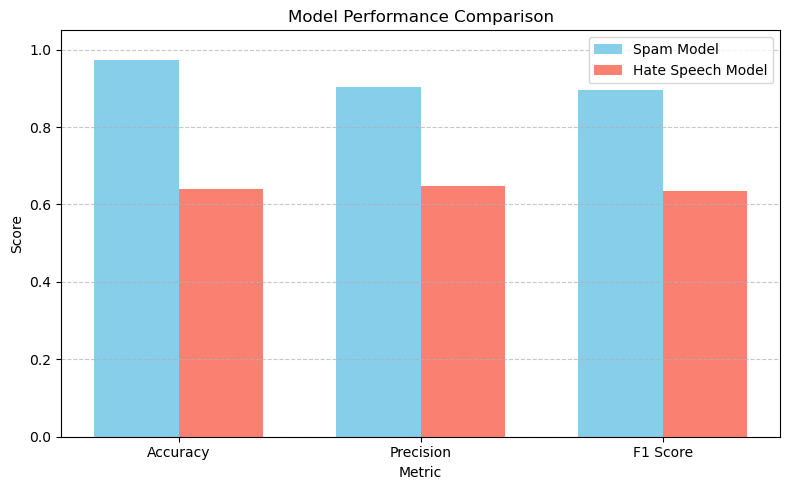

In [28]:
# Load or train both models with metrics
print("Initializing models...")
spam_model, spam_vectorizer, spam_metrics = load_or_train_model('spam')
hate_model, hate_vectorizer, hate_metrics = load_or_train_model('hate')

# Display model performance metrics
print("\nModel Performance Metrics:")
print(f"SPAM MODEL:")
print(f"  Accuracy: {spam_metrics['accuracy']:.2f}")  # Format to 2 decimal places
print(f"  Precision: {spam_metrics['precision']:.2f}")
print(f"  F1 Score: {spam_metrics['f1']:.2f}")

print(f"\nHATE SPEECH MODEL:")
print(f"  Accuracy: {hate_metrics['accuracy']:.2f}")
print(f"  Precision: {hate_metrics['precision']:.2f}")
print(f"  F1 Score: {hate_metrics['f1']:.2f}")

# Store Data for Graph
metrics_names = ['Accuracy', 'Precision', 'F1 Score']
spam_values = [spam_metrics['accuracy'], spam_metrics['precision'], spam_metrics['f1']]
hate_values = [hate_metrics['accuracy'], hate_metrics['precision'], hate_metrics['f1']]

x = range(len(metrics_names))  # 0, 1, 2

# Plot our graph
plt.figure(figsize=(8, 5))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], spam_values, width=bar_width, label='Spam Model', color='skyblue')
plt.bar([i + bar_width/2 for i in x], hate_values, width=bar_width, label='Hate Speech Model', color='salmon')

# Labeling
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(ticks=x, labels=metrics_names)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


### Classification function

In [29]:
def classify_text(text):
    """Classify text with both models and return predictions with confidence scores"""
    cleaned = preprocess_text(text)  # Clean the input text
    
    # Spam classification
    spam_vec = spam_vectorizer.transform([cleaned])  # Vectorize text
    spam_pred = spam_model.predict(spam_vec)[0]  # Get prediction (0 or 1)
    spam_prob = spam_model.predict_proba(spam_vec)[0][spam_pred]  # Get probability of prediction
    
    # Hate speech classification
    hate_vec = hate_vectorizer.transform([cleaned]) # Vectorize text
    hate_pred = hate_model.predict(hate_vec)[0] # Get prediction (0 or 1)
    hate_prob = hate_model.predict_proba(hate_vec)[0][hate_pred] # Get probability of prediction
    
    # Return structured results
    return {
        'text': text,  # Original text
        'spam': {
            'prediction': spam_pred,  # Numerical prediction
            'label': models['spam']['output'][spam_pred],  # Human-readable label
            'confidence': spam_prob  # Confidence score
        },
        'hate': {
            'prediction': hate_pred,
            'label': models['hate']['output'][hate_pred],
            'confidence': hate_prob
        }
    }

### Length Metrics

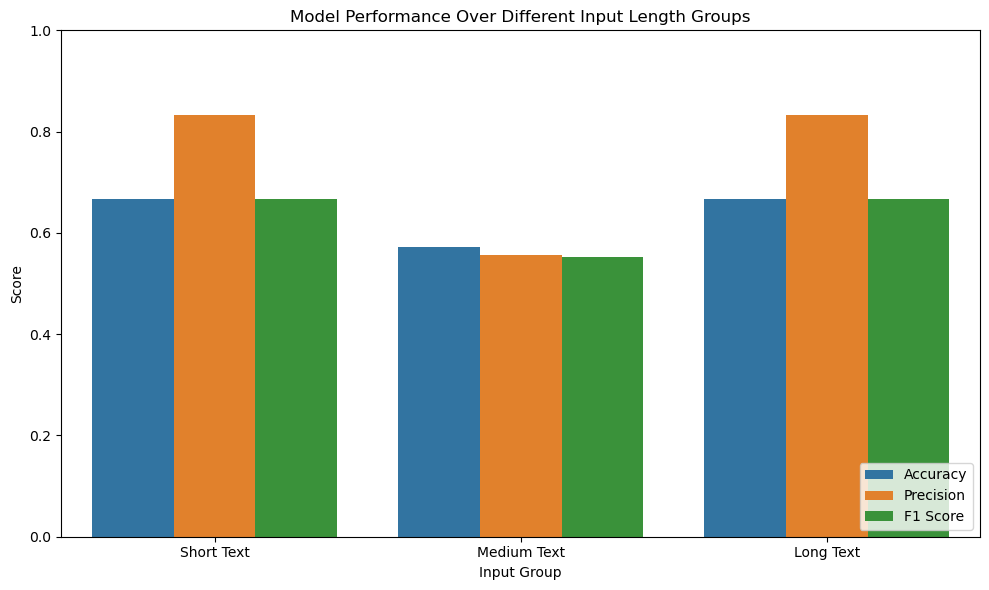

In [30]:
# Example texts and corresponding ground truth labels (1 = spam/hate, 0 = clean)
test_texts = [
    "Women are inferior to men in evry way",
    "We should deport all immigrants immmediately",
    "That religion is a cancer on our society",
    "I disagree with that political position",
    "The weather is terrible today",
    "That resturaunt has bad service",
    "WIN a FREE iPhone today! Text WIN to 12345",
    "You've won a $1000 Amazon gift card! click here: bit.ly/freegift",
    "Limited time offer! 50% of all products. Visit now: example.com/deal",
    "Hey, are we still meeting for lunch tommorow?",
    "Can you send me the report when you get a chance?",
    "Thanks for your help with the project yesterday!",
    "Nigger"
]
true_labels = [1,1,1,0,0,0,1,1,1,0,0,0,1]  # <- Update these manually to match the true class for spam/hate

# Classify and collect predictions
results = []
predictions = []

for text in test_texts:
    result = classify_text(text)
    results.append(result)

    # Combine predictions for a unified verdict (1 = spam/hate, 0 = clean)
    if result['spam']['prediction'] == 1 or result['hate']['prediction'] == 1:
        predictions.append(1)
    else:
        predictions.append(0)

# Group function
def get_length_group(text):
    length = len(text.split())
    #print(length)
    if length <= 5:
        return 'Short Text'
    elif length <= 9:
        return 'Medium Text'
    else:
        return 'Long Text'

# Build dataframe for analysis
df = pd.DataFrame({
    'text': test_texts,
    'label': true_labels,
    'prediction': predictions
})
df['group'] = df['text'].apply(get_length_group)

# Evaluate metrics per group
group_names = ['Short Text', 'Medium Text', 'Long Text']
accuracies, precisions, f1_scores = [], [], []

for group in group_names:
    group_df = df[df['group'] == group]
    if not group_df.empty:
        acc = accuracy_score(group_df['label'], group_df['prediction'])
        prec = precision_score(group_df['label'], group_df['prediction'], average='weighted', zero_division=0)
        f1 = f1_score(group_df['label'], group_df['prediction'], average='weighted', zero_division=0)
    else:
        acc = prec = f1 = 0
    accuracies.append(acc)
    precisions.append(prec)
    f1_scores.append(f1)

# Visualize results
df_metrics = pd.DataFrame({
    'Group': group_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'F1 Score': f1_scores
})
df_melted = df_metrics.melt(id_vars='Group', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Group', y='Score', hue='Metric')
plt.title('Model Performance Over Different Input Length Groups')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Input Group')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Test Sentences

In [31]:
# Text to classify - EDIT THIS VARIABLE TO TEST DIFFERENT TEXTS
test_text = "I do not agree with his political position!"


# Get and display classification results for the test text
result = classify_text(test_text)

# Print classification results
print(f"\nText: '{result['text']}'")
print("\nClassification Results:")
print(f"SPAM: {result['spam']['label']} (confidence: {result['spam']['confidence']:.1%})")  # Format as percentage
print(f"HATE: {result['hate']['label']} (confidence: {result['hate']['confidence']:.1%})")

# Make final determination based on model predictions; Three categories: Spam, Hate Speech, Clean
if result['spam']['prediction'] == 1:
    print("\nFINAL VERDICT: This is SPAM")
elif result['hate']['prediction'] == 1:
    print("\nFINAL VERDICT: This is HATE SPEECH")
else:
    print("\nFINAL VERDICT: This is CLEAN (not spam or hate speech)")


Text: 'I do not agree with his political position!'

Classification Results:
SPAM: NOT SPAM (confidence: 81.0%)
HATE: NOT HATE (confidence: 61.8%)

FINAL VERDICT: This is CLEAN (not spam or hate speech)
